# Power Calculations and Experiment Planning

When you read about them in a book, power calculations can feel very abstract. To make the concept more concrete, and to give you a chance to familiarize yourself with power calculation tools and the considerations that go into power calculations, in this exercise you will play the role of an experiment planner hired by a Non-Governmental Organization (NGO) named [Bandhan](https://www.bandhan.org/) in West Bengal, India. Bandhan is planning to roll out a program that provides livestock, cash, and some basic training to households in extreme poverty. They hope to demonstrate the value of cash and asset transfers, and so wish their program to take the form of a randomized experiment, with data being collected on both control and treatment households.

Your job will be to help them estimate how many households they should enroll in the program.

This was, in fact, a real program, and so the data you will be working with comes from the actual program (conducted in 2007, with followup data collection in 2010, 2017, and 2020), allowing us to do some retrospective comparison of your power calculations and what actually occurred.

## The Context

> Development economics has long posited that the poor may be poor for no good reason other than the fact that they started poor. This is the idea of a poverty trap, which has the implication that a one-time capital grant that makes very poor households significantly less poor ("big push") might set off a virtuous cycle that takes them out of poverty. Forty-three countries now embrace some version of this idea and make large transfers to over 3.1 million of their poorest households. In particular, the "Targeting the Ultra Poor" (TUP) intervention, pioneered by BRAC in Bangladesh, employs a multifaceted approach, offering poor households an asset transfer, consumption support, savings, and training in the hopes of unlocking a poverty trap.

- [*Long-Term Effects of the Targeting the Ultra Poor Program*](https://economics.mit.edu/research/publications/long-term-effects-targeting-ultra-poor-program), Abhijit Banerjee, Esther Duflo, and Garima Sharma, 2021.

In 2007, Bandhan in West Bengal, India created a pilot program to provide direct, unconditional transfers of productive livestock and a 30 or 40 week stipend of 90 rupees a week (about 7 US dollars a week using the [Purchasing Power Parity (PPP)](https://en.wikipedia.org/wiki/Purchasing_power_parity) exchange rate). The program targeted the poorest households in these villages based on range of criteria, and the average eligible household was later estimated to have a consumption level of about 1.35 2018 US Dollars per capita per day in PPP terms $.^1$

Because the goal of the program was, in significant part, to demonstrate the effect of direct asset transfers, Bandhan identified twice as many eligible households as it could support in the pilot and randomly selected half of the households to act as controls and half to be treated $.^2$ Treated households were offered assets from a menu of options, from the most common choice was productive livestock (e.g., cows and goats). $^3$ Bandhan's contact with the households came to an end 18 months after the households were initially provided their livestock and cash transfers began.

Although data was collected on a huge range of attributes of the households in this program, our focus will be on per capita household expenditures in 2018 US Dollars (PPP). 

(Note that these households certainly were not buying their food with dollars, and in most cases they weren't even buying most of their food with rupees — consumption estimates in this type of study are calculated by collecting detailed data on what household members have consumed in the past week, then estimating the price one would pay to buy those goods in local markets and using [PPP conversion rates](https://en.wikipedia.org/wiki/Purchasing_power_parity) conversion rates to convert that into US Dollars).



## Exercises

### Exercise 1

Load a thinned version of household-level survey data from [Banerjee, Duflo, and Sharma (2021)'s](https://economics.mit.edu/research/publications/long-term-effects-targeting-ultra-poor-program) evaluation of the Bandham program [here](https://github.com/nickeubank/MIDS_Data/tree/master/cash_transfers). 

This is just a version of the replication data for that paper ([which can be found here](https://www.openicpsr.org/openicpsr/project/130362)) with only the variables that are relevant for our analysis.

In [2]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)
data = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/master/cash_transfers/TUP_cash_transfers.csv"
)
data.head()

,treatment,pc_exp_month_bl,pc_exp_month_el1,pc_exp_month_el2,pc_exp_month_el3
0,0,37.152084,41.816093,50.286613,60.728490
1,0,19.388021,27.816334,47.899952,88.277290
2,1,33.698770,58.222298,69.547070,69.601420
3,0,26.839483,NaN,NaN,48.802390
4,1,43.763836,45.879470,71.511020,30.258686


### Exercise 2

The first step in doing any power calculations is to establish an estimate of the baseline level of variation that exists in the dependent variable you wish to study. In this case, that variable is Per Capita Monthly Expenditures, and the baseline survey values of expenditures are in `pc_exp_month_bl` (the `_bl` stands for "baseline", meaning this data was collected prior to any households receiving asset transfers and indeed any households being assigned to treatment or control).

What is the mean and standard deviation of `pc_exp_month_bl` in the baseline survey? Divide by 30 to confirm our average household has the expected per capita expenditure level of about US Dollar 1.35 (PPP) a day.

You'll use these quantites a lot, so assign them to variables.

In [3]:
mean_exp = data["pc_exp_month_bl"].mean()
std_exp = data["pc_exp_month_bl"].std()

mean_daily_exp = mean_exp / 30
std_daily_exp = std_exp / 30

print(f"Mean monthly expenditure: {mean_exp:.2f}")
print(f"Standard deviation of monthly expenditure: {std_exp:.2f}")
print(f"Mean daily expenditure: {mean_daily_exp:.2f}")
print(f"Standard deviation of daily expenditure: {std_daily_exp:.2f}")

Mean monthly expenditure: 40.74
Standard deviation of monthly expenditure: 24.26
Mean daily expenditure: 1.36
Standard deviation of daily expenditure: 0.81


### Exercise 3

For these exercises, we'll use the `power` module in `statsmodels`. [You can read about it here.](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations)

Since we're comparing means in a continuous variable (expenditures) from two samples of households, we will use `TTestIndPower` in `statsmodels.stats.power`. Import this class and instantiate a new instance (for some reason this is class based, so you have to start of with a command like `my_power = TTestIndPower()`). 

Note that a common situation in data science is testing a difference in *proportions* between groups (e.g., across treatment arms). This situation arises when your dependent variable is binary, and so each group's mean is just the share of observations for whom the binary variable is 1. This comes up a lot with apps and websites — e.g., "clicked an ad," "subscribed," "made a purchase." 

For that reason, there's actually a full sub-class of power calculating tools for [proportions you should be aware of.](https://www.statsmodels.org/stable/stats.html#proportion) Basically, because the standard deviation of a binary variable is just $\sqrt{p * (1-p)}$, power calculations become really simple. For example, you may wish to identify the sample size required to get confidence intervals of a given size using a tool like [confint_proportions_2indep](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.confint_proportions_2indep.html#statsmodels.stats.proportion.confint_proportions_2indep).

But the most common use of a power test remains evaluating whether one can reject a null hypothesis of no effect, so we'll start with that here.

In [4]:
from statsmodels.stats.power import TTestIndPower

my_power = TTestIndPower()

### Exercise 4

[TTestIndPower has three methods](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.html#statsmodels.stats.power.TTestIndPower) — `plot_power`, `power`, and `solve_power` — but `solve_power` does everything `power` does, so there are basically two methods.

The idea of `solve_power` is that you give it all but one parameter of a power calculation — minimum detectable effect, number of observations, power, and p-value $\alpha$ threshold — and it will solve for the omitted variable.

To get a quick flavor for how this works, set: 

- Minimal Detectable Effect (`effect_size`) to `0.5` (we'll talk about the units of that argument soon), 
- `alpha` to `0.05`, 
- `ratio` to `1` (this is the ratio of between the number of observations being treated and the number in control — in this study, the target was to have these be equal, as that provides the best statistical power for a given total number of observations).
- `power` to `0.8`
- `alternative` to `two-sided` (we want to do a two-tailed t-test, as you could imagine social unrest caused by transfers could make people worse off).
- `nobs1` to `None`. By passing `None`, we're telling `solve_power` this is the quantity we want it to solve for.

So in other words, we're asking:

- how many observations do we need to have in the treatment arm,
- assuming we'll have the same number also in the control arm,
- to have an 80% chance
- of rejecting the null hypothesis of no-effect at a significance threshold of 0.05
- if the true effect is of size 0.5?

What's the answer?

In [5]:
nobs1 = my_power.solve_power(
    effect_size=0.5, alpha=0.05, power=0.8, ratio=1, alternative="two-sided", nobs1=None
)

print(f"Number of observations in treatment arm: {nobs1:.0f}")

Number of observations in treatment arm: 64


### Exercise 5

Of all these quantities, perhaps the most obscure is the Minimal Detectable Effect (`effect_size`). What is this 0.5? Where did it come from? And how did you do all that without telling it that standard deviation you had me calculate?

If you check the docs for `solve_power`, you'll see that you're supposed to pass `effect_size` the "standardized effect size, difference between the two means divided by the standard deviation. `effect_size` has to be positive."

In other words, when we passed 0.5, we weren't saying we wanted to be able to detect an effect of 0.5 2018 US Dollars (PPP) per capita per month, we were saying we wanted to detect an effect of 1/2 standard deviation. 

Given the standard deviation in our baseline survey was about 24 Dollars, that means we were saying we wanted to detect an effect size of about 12 US Dollars. 

Is that a lot? Well, the average per capita monthly expenditures in the baseline survey was about 41 Dollars, so it's an increase in expenditures of about 25%. 

OK, but is that what we should use?

Well, the idea of a Minimal Detectable Effect is that you want to set it at a level where (a) if this *was* the real effect when you rejected the null, you'd be happy you did the experiment and, presumably, would be comfortable scaling up the treatment, but also (b) if the true effect were any smaller, you wouldn't want to reject the null hypothesis and scale up the treatment.

Basically, if you set this too high, you may run an under-powered experiment where you miss out on learning that your treatment was effective; if you set this too low, you're spending time and money collecting more data than is probably necessary given you might reject the null at a point estimate where you still wouldn't scale up the treatment.

So what value makes sense here? That's a question you'd want to start off by asking the stakeholders. Since Bandhan wants to use this to promote cash transfers, they probably need the effect to be relatively large to be convincing. Let's assume that, three years after the intervention, they feel they need to show that incomes have increased by at least 30%. 

What value does that imply should be passed to `effect_size`? What is the new implied number of treated households they'll need? How many households total?

In [6]:
# calculate the change in income that represents a 30% increase
increase = mean_exp * 0.3
alpha = 0.05
power = 0.8
ratio = 1
alternative = "two-sided"

# caculate the std. effect size
effect_size_q5 = increase / std_exp

my_power_q5 = TTestIndPower()

nobs1_q5 = my_power_q5.solve_power(
    effect_size=effect_size_q5,
    alpha=alpha,
    power=power,
    ratio=ratio,
    alternative=alternative,
    nobs1=None,
)

# calculating the total number of households needed
total_households_needed_q5 = (
    2 * nobs1_q5
)  # since the ratio is 1, we need an equal number in both groups

print(f"Effect size (standardized): {effect_size_q5:.2f}")
print(f"Number of observations in treatment arm: {nobs1_q5:.0f}")
print(f"Total number of households needed: {total_households_needed_q5:.0f}")

Effect size (standardized): 0.50
Number of observations in treatment arm: 63
Total number of households needed: 126


> As we have caculated a standardized effect size of 0.50, aiming to detect a 30% increase in baseline average monthly expenditures, which translates to needing 63 observations in the treatment arm. This leads to a total of 126 households needed when considering both treatment and control groups, given the 1:1 ratio.

### Exercise 6

Let's also suppose that because Bandhan really wants to sell their result, they also want to ensure no one claims it might have arisen by chance. What parameter would you adjust, and in what direction? Try modifying it and get a new observation requirement (can you predict what the change in num of observations will be before you do it?).

> Given that p-values vary with different samples, we want to increase `power` to reduce the risk that we run into samples that would lead us to reject the null hypothesis when it is actually true. We're increasing `power` to 0.95 which should lead to an increase in the number of observations required.

In [7]:
effect_size_q6 = effect_size_q5
ratio = 1
alternative = "two-sided"
alpha = 0.05

# ajust power to make the test more stringent
power_adjusted = 0.95

# calculating the new number of observations required
nobs1_adjusted = my_power.solve_power(
    effect_size=effect_size_q6,
    alpha=alpha,
    power=power_adjusted,
    ratio=ratio,
    alternative=alternative,
    nobs1=None,
)

# calculating the total number of households needed with the adjusted alpha
total_households_needed_adjusted = 2 * nobs1_adjusted

print(f"Number of adjusted observations in treatment arm: {nobs1_adjusted:.0f}")
print(
    f"Total number of adjusted households needed: {total_households_needed_adjusted:.0f}"
)

Number of adjusted observations in treatment arm: 103
Total number of adjusted households needed: 207


> As expected, the new calculation suggests that we need 103 observations in the treatment arm, equivalent to a total of 206 households. This allows testing results to be more robust to sampling.

### Exercise 7

Now suppose that your stakeholder is budget constrained to only being able to enroll a total of 100 (50 in each arm). Assuming an alpha of `0.05` and a power of `0.8`, what is their minimal detectable effect size (in dollars)?

In [8]:
nobs1_q7 = 50  # num of observations in one arm
alpha = 0.05
power = 0.8
ratio = 1
alternative = "two-sided"
standard_deviation = std_exp


my_power_q7 = TTestIndPower()

# for the minimal detectable effect size in standardized units
mdes_standardized = my_power.solve_power(
    effect_size=None,
    nobs1=nobs1_q7,
    alpha=alpha,
    power=power,
    ratio=ratio,
    alternative=alternative,
)

# converte the MDES to dollars
mdes_in_dollars = mdes_standardized * standard_deviation

print(f"Minimal Detectable Effect Size (standardized units): {mdes_standardized:.2f}")
print(f"Minimal Detectable Effect Size (in dollars): ${mdes_in_dollars:.2f}")

Minimal Detectable Effect Size (standardized units): 0.57
Minimal Detectable Effect Size (in dollars): $13.73


>The results show that under the given constraints and desired statistical parameters, our study is powered to detect an effect size of at least 13.73 USD per capita per month in expenditures between the treatment and control groups.

### Exercise 8

Suppose your stakeholder wants to see a few different scenarios to see how different experiment sizes would impact power given different effect sizes. Let's use `plot_power`. Pass it an array of treatment arm observation counts you want evaluated (I'd recommend `np.arange()`) between 20 and 100, along with effect sizes of 0.2, 0.4, and 0.6 (again, use `np.arange()`).

If the stakeholder decided they wanted power above 90% — they're only gonna get a chance to do this once, after all! — what kind of sample size would they need with a minimal detectable effect size of 0.6? (Approximately).

You may need to check the docs to figure out how to use it.

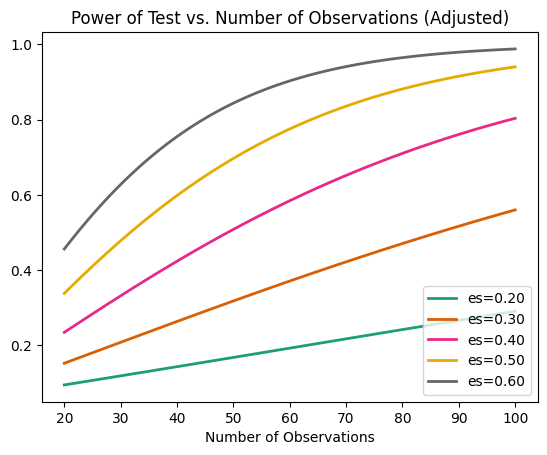

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# parameters for the plot
effect_sizes = np.arange(0.2, 0.61, 0.1)
nobs_range = np.arange(20, 101, 1)  # counts from 20 to 100
alpha = 0.05

# create an instance of TTestIndPower for plotting
power_analysis = TTestIndPower()

# plot power curves for different effect sizes across a range of sample sizes
fig = power_analysis.plot_power(
    dep_var="nobs",
    nobs=nobs_range,
    effect_size=effect_sizes,
    alpha=alpha,
    title="Power of Test vs. Number of Observations (Adjusted)",
)

plt.show()

In [10]:
from statsmodels.stats.power import tt_ind_solve_power

# Desired parameters
effect_size_q8 = 0.6  # minimal detectable effect size
alpha = 0.05
power_q9 = 0.9  # greater than 90%
ratio = 1

# use the tt_ind_solve_power function to calculate the required sample size per group
nobs1_required = tt_ind_solve_power(
    effect_size=effect_size_q8,
    alpha=alpha,
    power=power_q9,
    ratio=ratio,
    alternative="two-sided",
)

total_required_size = 2 * nobs1_required

print(f"Required number of observations per group: {nobs1_required:.0f}")
print(f"Total required sample size (both groups): {total_required_size:.0f}")

Required number of observations per group: 59
Total required sample size (both groups): 119


>The results indicate that to achieve a power greater than 90% for detecting a minimal detectable effect size of 0.6, with an alpha of 0.05, our study would need 59 participants in each group (treatment and control), leading to a total of 119 participants for the entire study.

## Extra Credit Extension

### Exercise 9

As noted above, this study actually was conducted, so we know the actual treatment effect. Calculate that treatment effect 3 years after these families first received asset transfers by calculating the difference in `pc_exp_month_el2` between the `treatment == 1` and `treatment == 0` groups.


In [11]:
# mean of 'pc_exp_month_el2' for treatment and control groups
mean_exp_treatment = data[data["treatment"] == 1]["pc_exp_month_el2"].mean()
mean_exp_control = data[data["treatment"] == 0]["pc_exp_month_el2"].mean()

# treatment effect
treatment_effect = mean_exp_treatment - mean_exp_control

print(f"Mean expenditure (treatment group): {mean_exp_treatment:.2f}")
print(f"Mean expenditure (control group): {mean_exp_control:.2f}")
print(f"Treatment effect (difference in mean expenditure): {treatment_effect:.2f}")

Mean expenditure (treatment group): 67.55
Mean expenditure (control group): 61.40
Treatment effect (difference in mean expenditure): 6.15


### Exercise 10

What was the statistical power of the actual test? That is, what was the probability, given this effect size and the number of observations in the study, that they would reject the null hypothesis of no effect at alpha=0.05 and given the actual final sample sizes?

In [12]:
std_el2 = data["pc_exp_month_el2"].std()
mean_el2 = data["pc_exp_month_el2"].mean()
mean_el2_treatment = data[data["treatment"] == 1]["pc_exp_month_el2"].mean()
mean_el2_control = data[data["treatment"] == 0]["pc_exp_month_el2"].mean()

# num of observations in 'pc_exp_month_el2' for treatment and control groups
nobs_treatment = data[data["treatment"] == 1]["pc_exp_month_el2"].count()
nobs_control = data[data["treatment"] == 0]["pc_exp_month_el2"].count()

# calculate the effect size
observed_effect_q10 = mean_el2_treatment - mean_el2_control
effect_size_q10 = observed_effect_q10 / std_el2

# calculate the power
power_analysis = TTestIndPower()
power_q10 = power_analysis.solve_power(
    effect_size=effect_size_q10,
    nobs1=nobs_treatment,
    alpha=alpha,
    ratio=nobs_treatment / nobs_control,
    alternative="two-sided",
)

print(f"Observed effect size: {observed_effect_q10:.2f}")
print(f"Effect size (standardized): {effect_size_q10:.2f}")
print(f"Power of the test: {power_q10:.2f}")

Observed effect size: 6.15
Effect size (standardized): 0.20
Power of the test: 0.89


### Exercise 11

What would the power be if Bandhan had only enrolled 200 households per arm? 


In [13]:
effect_size_q11 = effect_size_q10
nobs1 = 200  # num of observations per group
alpha = 0.05
power = None
ratio = nobs_treatment / nobs_control

power_analysis = TTestIndPower()

# calculating the statistical power with the adjusted sample size
new_power = power_analysis.solve_power(
    effect_size=effect_size_q11,
    nobs1=nobs1,
    alpha=alpha,
    power=power,
    ratio=ratio,
    alternative="two-sided",
)

print(f"New Statistical Power with 200 households per arm: {new_power:.2f}")

New Statistical Power with 200 households per arm: 0.56


>This indicates that with these parameters, enrolling only 200 households per arm would have resulted in a power of 0.56, meaning we could expect that the Minimal Detectable Effect from 44% of samples not to be evident given our chosen `alpha`.

### Exercise 13

The idea of the "power" of a test is that, when we draw a sample from a population, there's some variation in who happens to end up in that sample. Consequently, even if the *true* effect size in the population is equal to our Minimal Detectable Effect, there's some probability that when we compare treated and untreated outcomes for the $N$ people who actually end up in the study, that Minimal Detectable Effect may not be evident in that sample (at the level of statistical significance $\alpha$ we have chosen).

Given that, one way to think of power is: "If the true effect in the population is our Minimal Detectable Effect, then if I were able to re-run this experiment over and over — drawing new people into the study and testing the difference in outcomes between the control and treated sample each time — then in what percentage of those instances of the experiment would I reject the null hypothesis of no effect?" Power of 80% means that we'd expect to reject the null of no effect in 80% of those many experiments.

Well, we can basically do that thought experiment with this data! 

To do the experiment you did the power calculations for in Exercise 11, we just need to sample 200 observations from the treated group and 200 from the control group, treat that as our experimental sample, and estimate the difference in per capita month expenditures between those two groups (along with the associated p-value).

Then we can repeat that over and over to simulate "re-running" the experiment, each time drawing a new sample of 200 treated observations and 200 control observations. Then we can store the p-values from all these "re-run" experiments and see how often we reject the null of no effect!

Note that when you do this experiment, we have to sample our 200 observations from each treatment arm *with replacement*, just as you would when bootstrapping (if that means anything to you — if it doesn't, don't worry about it). 

So: write a loop where, on each pass, you draw 200 observations (with replacement) from treatment and 200 from control, then calculate the treatment effect and p-value for that sample. Repeat this 10,000 times. 

In what share of cases would you reject the null of no effect at alpha = 0.05?

In [14]:
from scipy.stats import ttest_ind
import numpy as np

# drop NA 'pc_exp_month_el2' from both treatment and control groups
treatment_data = data[data["treatment"] == 1]["pc_exp_month_el2"].dropna()
control_data = data[data["treatment"] == 0]["pc_exp_month_el2"].dropna()

# initialize a list to store p-values
p_values = []

# num of simulations
num_simulations = 10000

# loop the experiment 10,000 times
for _ in range(num_simulations):
    # Sampling with replacement
    sample_treatment = treatment_data.sample(n=200, replace=True)
    sample_control = control_data.sample(n=200, replace=True)

    # calculate the treatment effect and p-value for the sample
    _, p_value = ttest_ind(sample_treatment, sample_control)

    # store the p-value
    p_values.append(p_value)

# calculate the share of cases where the null hypothesis of no effect is rejected at
# alpha = 0.05
share_reject_null = np.mean(np.array(p_values) < 0.05)

print(f"Share of cases rejecting the null hypothesis: {share_reject_null:.2f}")

Share of cases rejecting the null hypothesis: 0.54


>This outcome is in line with the calculation we did in the previous exercise. This lower power means there's a higher chance of not detecting an effect that truly exists (a Type II error), highlighting the importance of sample size in planning studies to achieve sufficient power.

### Exercise 14

Repeat 11 and 13 with 300 observations per arm.

In [15]:
# repeat 11

effect_size_q11 = effect_size_q11
nobs1_q11_new = 300  # adjusting number of observations per group to 300
alpha = 0.05
ratio = 1

# calculate the statistical power with the new sample size
power_analysis = TTestIndPower()
new_power_300 = power_analysis.solve_power(
    effect_size=effect_size_q11,
    nobs1=nobs1_q11_new,
    alpha=alpha,
    ratio=ratio,
    alternative="two-sided",
)

print(
    f"Statistical Power with 300 observations per arm for Exercise 11: {new_power_300:.2f}"
)

Statistical Power with 300 observations per arm for Exercise 11: 0.70


In [17]:
# repeat 13

p_values_300 = []

# adjust the num of obs per arm for the simulation
num_observations_per_arm = 300

# Repeat the experiment 10,000 times
for _ in range(10000):
    sample_treatment_300 = treatment_data.sample(
        n=num_observations_per_arm, replace=True
    )
    sample_control_300 = control_data.sample(n=num_observations_per_arm, replace=True)

    _, p_value_new = ttest_ind(sample_treatment_300, sample_control_300)
    p_values_300.append(p_value_new)

# Calculate the share of cases rejecting the null hypothesis
share_reject_null_300 = np.mean(np.array(p_values_300) < 0.05)

print(
    f"Share of cases rejecting the null hypothesis with 300 observations per arm"
    f" for Exercise 13: {share_reject_null_300:.2f}"
)

Share of cases rejecting the null hypothesis with 300 observations per arm for Exercise 13: 0.72


### Exercise 15

What did you learn from Exercises 9-14?

>From Exercises 9 to 14, we explored the impact of sample size on statistical power through a case study on cash transfers. We discovered that the actual effect was a $6.15 monthly increase in expenditures for treated households. Given the actual treatment and control observations, that resulted in a power of 89%.
>
>Additionally, we got to play around with the number of observations in order to understand what would have happened if the experiment had been done with fewer observations: with 200 observations per arm, the statistical power was only 0.55, meaning that the effect might not have been evident and the results discarded. Increasing the sample size to 300 per arm raised the power to about 0.73. Simulations further demonstrated this effect: the null hypothesis was rejected in 54% of trials with 200 samples, improving to 71% with 300 samples. These exercises highlighted the critical balance between sample size, effect size, and statistical power, emphasizing the importance of careful planning in research design to achieve reliable results.

## Footnotes

1. The poorest households were identified in two steps. First, residents across 120 village hamlets ranked households into five wealth quintiles. Among households ranked in the bottom quintile, Bandhan then verified eligibility per seven criteria: (i) presence of an able-bodied female member (to manage the asset), (ii) no credit access, (iii) landholding below 0.2 acres, (iv) no ownership of productive assets, (v) no able-bodied male member, (vi) presence of school-aged children who were working instead of attending school, and (vii) primary source of income being informal labor or begging. Households had to meet the first two criteria and at least three of the remaining five in order to be eligible for the TUP intervention.
2. The [ethics of randomization in these types of programs](https://www.povertyactionlab.org/resource/ethical-conduct-randomized-evaluations) is subject of a rich literature, and there are currently an extensive set of guidelines used by researchers developing these types of programs.
3. Of the 514 offered the livestock and cash transfers, only 266 accepted. The treatment estimates that follow are thus estimates of the effect of *offering* these transfers. Households that accepted the offers might differ systematically from those that do not, so the study simply compares those *offered* the transfer to those who did not). This is what's called an estimate of the "intention to treat" effect, and is thus *likely* an under-estimate of the effect of cash transfers that would be observed if uptake were greater.